# Test the StarNet model

This notebook takes you through the steps of how to test a trained model on given test data sets.
Requirements:
* python packages: `numpy h5py keras matplotlib seaborn sklearn scipy`
* data files:
    - high_snr_test_data.h5
    - low_snr_test_data.h5
    - mean_and_std.npy
    - starnet_cnn.h5

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import h5py
import time
import scipy.stats as stats
from matplotlib import gridspec

datadir = '/home/ubuntu/starnet_data/'


Using TensorFlow backend.


**Obtain data for normalizing labels**

In [7]:
mean_and_std = np.load(datadir + 'mean_and_std.npy')
mean_labels = mean_and_std[0]
std_labels = mean_and_std[1]
num_labels = mean_and_std.shape[1]

**Define function to denormalize labels**

In [8]:
def denormalize(lb_norm):
    return ((lb_norm*std_labels) + mean_labels)

**Define functions to obtain test data**

In [11]:
def get_data(filename):
    f = h5py.File(datadir + filename, 'r')
    spectra_array = f['spectra'][:]
    spectra_array = spectra_array.reshape((spectra_array.shape[0],spectra_array.shape[1],1))
    ap_ids = f['Ap_IDs'][:]
    labels_array = np.column_stack((f['TEFF'][:],f['LOGG'][:],f['FE_H'][:]))
    snr_array = f['combined_snr'][:]  
    f.close()
    return  (ap_ids, snr_array, spectra_array, labels_array)

**Load test data and model**

In [15]:
test_1_ap_ids, test_1_snr, test_1_spectra, test_1_labels = get_data('high_snr_test_data.h5')
print('High S/N test set contains '  + str(len(test_1_spectra))+' stars')
test_2_ap_ids, test_2_snr, test_2_spectra, test_2_labels = get_data('low_snr_test_data.h5')
print('Low S/N test set contains '  + str(len(test_2_spectra))+' stars')
model = keras.models.load_model(datadir + 'starnet_cnn.h5')

High S/N test set contains 2780 stars
Low S/N test set contains 17506 stars


** Predict on test sets**

In [17]:
time1 = time.time()
test_1_pred = denormalize(model.predict(test_1_spectra))
test_2_pred = denormalize(model.predict(test_2_spectra))
print("{0:.2f}".format(time.time()-time1)+' seconds to make '+str(len(test_1_spectra)+len(test_2_spectra))+' predictions')

8.87 seconds to make 20286 predictions


** Show residuals on high S/N label predictions**

Note: If top plot does not show gridlines, then simply run the cell again. This is a bug.

In [18]:
# label names
label_names = ['$T_{\mathrm{eff}}$',' $\log(g)$','[Fe/H]']

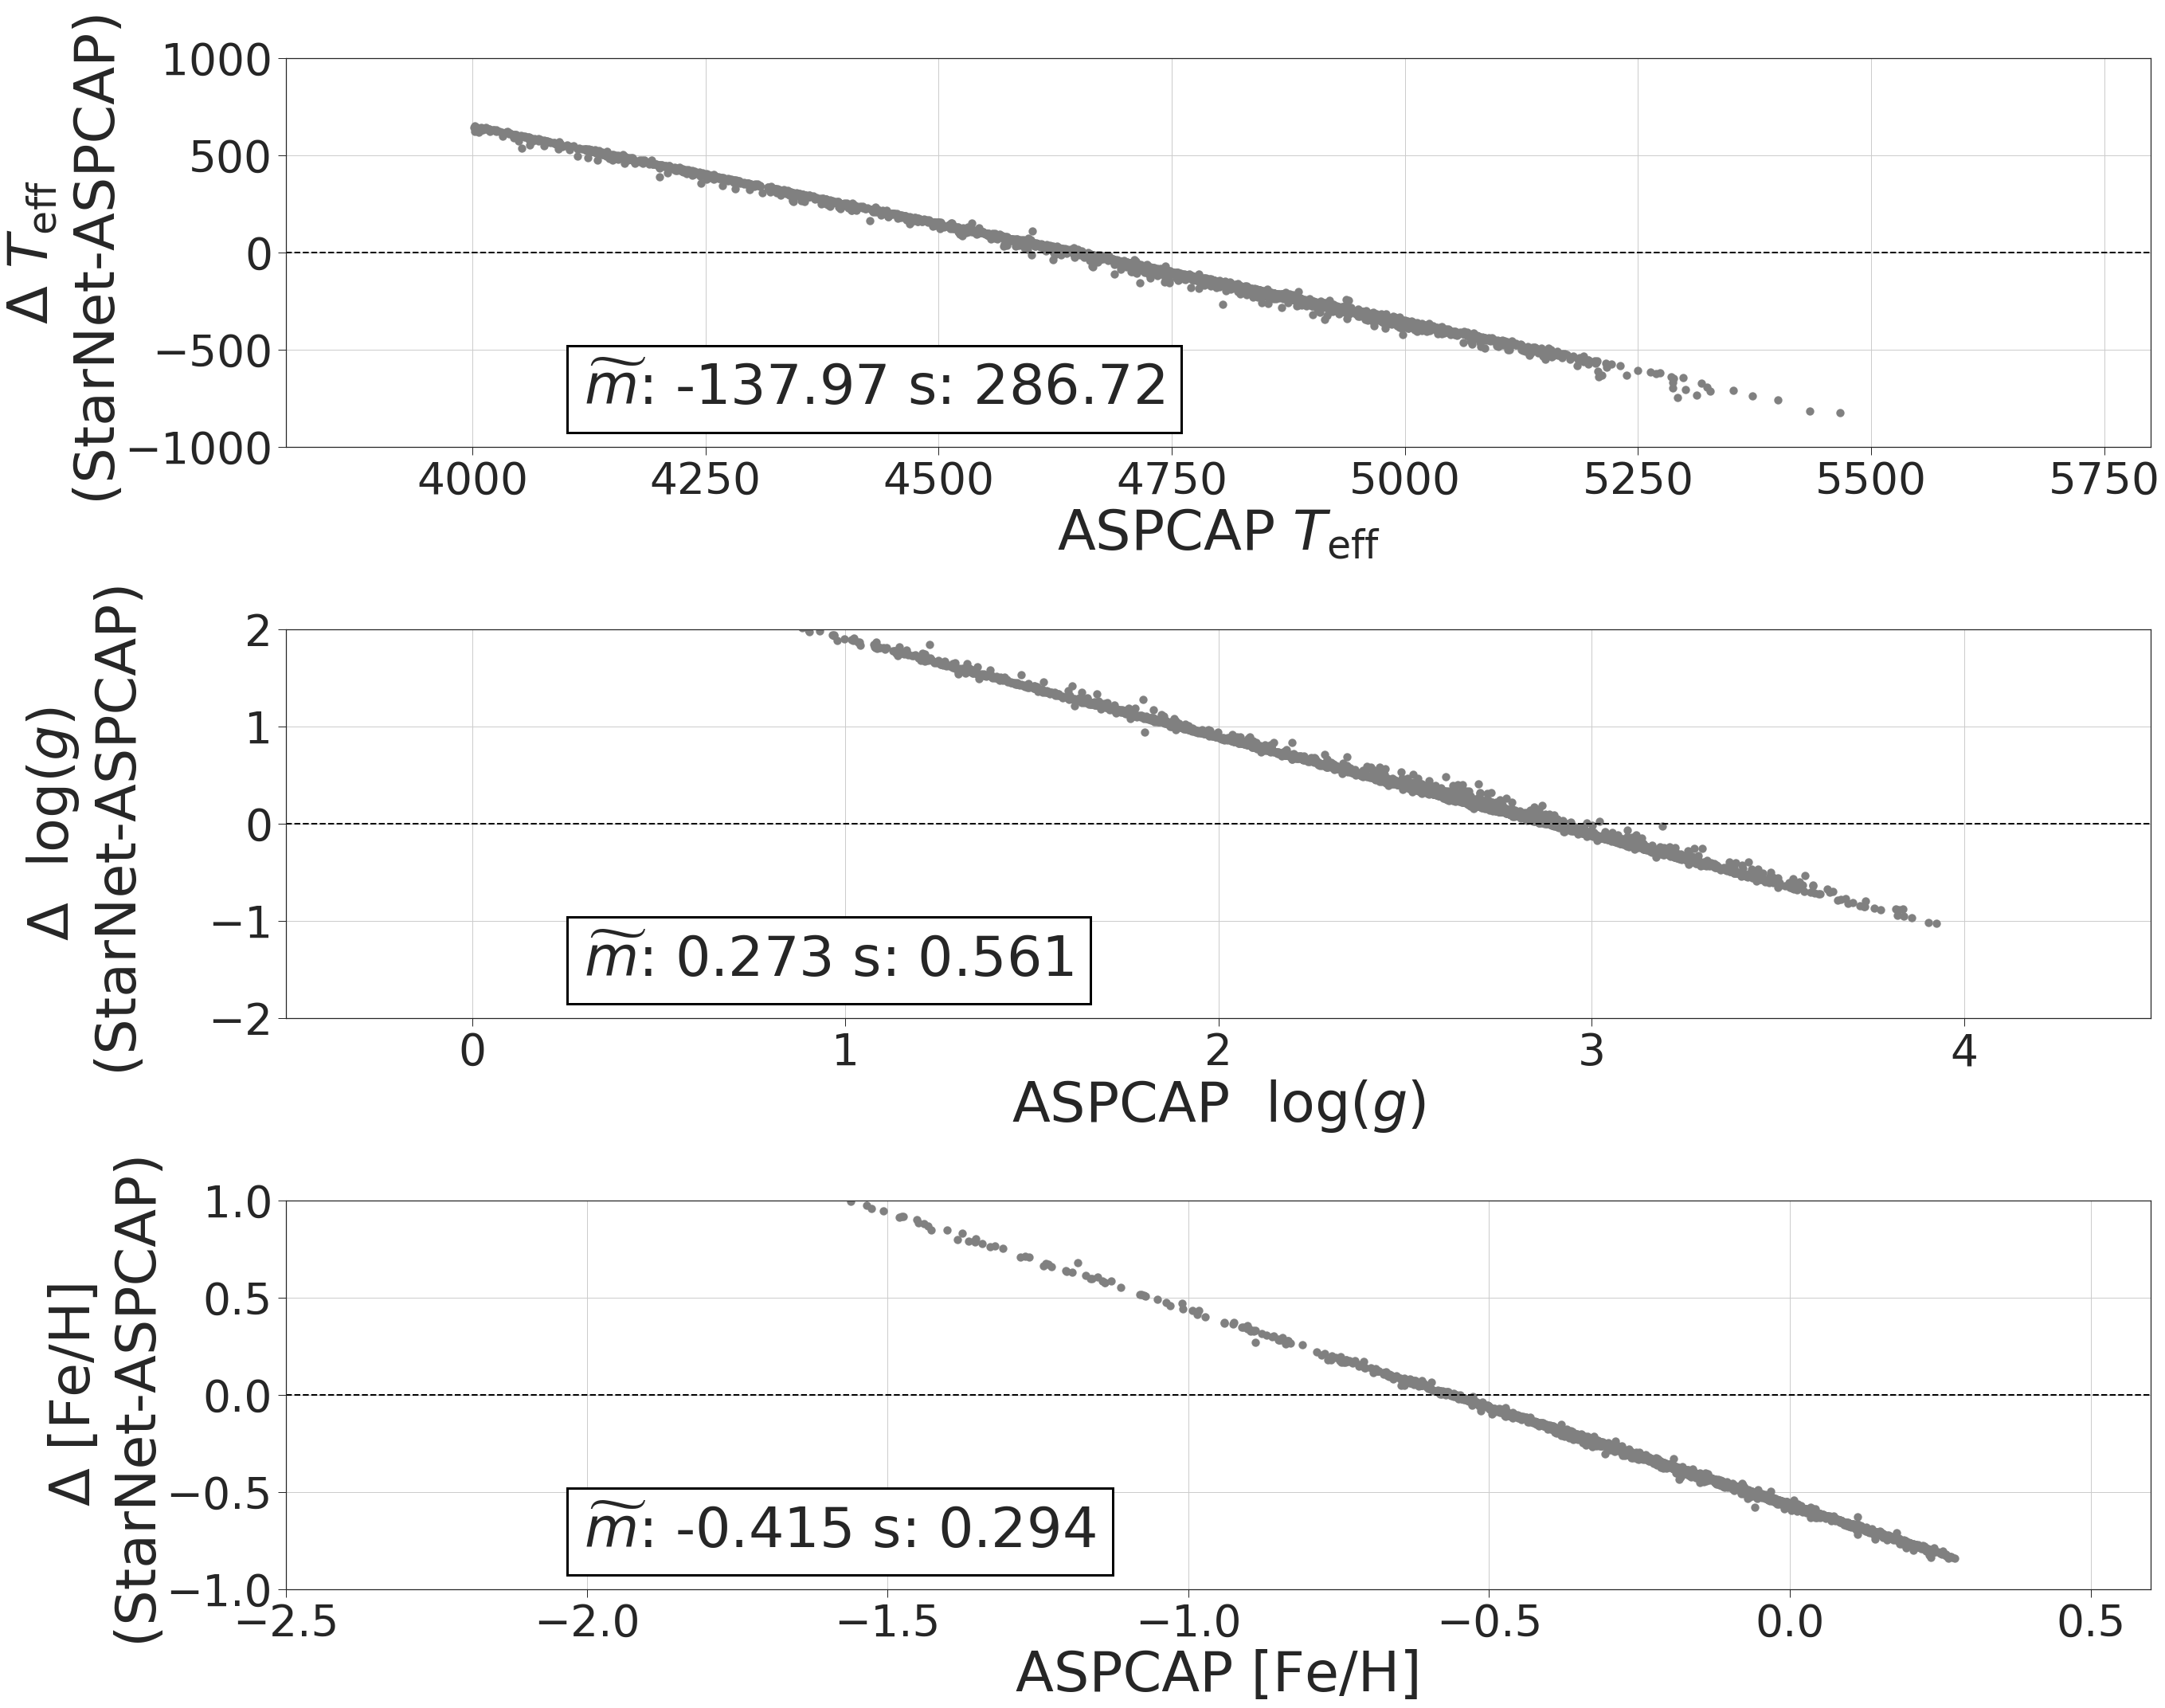

In [26]:
all_targets = test_1_labels
all_pred = test_1_pred

x_lab='ASPCAP'
y_lab='StarNet'

resid = all_pred - all_targets
bias = np.median(resid, axis=0)
scatter = np.std(resid, axis=0)

#r2 = r2_score(all_targets, all_pred,multioutput='raw_values')

lims = [[(3800,5800),(-0.50,4.50),(-2.5,0.6)],[(-1000,1000),(-2.0,2.0),(-1.,1.)]]

fig = plt.figure(figsize=(38, 30)) 
gs = gridspec.GridSpec(3, 1)

for i in range(num_labels):

    ax0 = plt.subplot(gs[i,0])
    ax0.set_facecolor('white')
    ax0.grid(True)
    points = ax0.scatter(test_1_labels[:,i], resid[:,i], c='gray', s=100)

    sns.set_style('ticks')
        
    ax0.set_xlabel(x_lab + ' ' + label_names[i], fontsize=70)
    if i==1:
        ax0.set_ylabel('$\Delta$ ' + label_names[i] + '\n('+y_lab+'-'+x_lab+')\n', fontsize=70)
    else:
        ax0.set_ylabel('$\Delta$ ' + label_names[i] + '\n('+y_lab+'-'+x_lab+')', fontsize=70)  
    
    ax0.tick_params(labelsize=55,width=1,length=10)
    
    ax0.set_xlim(lims[0][i])
    ax0.set_ylim(lims[1][i])
    ax0.plot([lims[0][i][0],lims[0][i][1]], [0,0], 'k--', lw=2)
    

    bbox_props = dict(boxstyle='square,pad=0.3', fc='w', ec='k', lw=3)
    if i==0:
        plt.figtext(0.27, (1-((i*0.332)+0.24)), 
                    '$\widetilde{m}$=' +'{0:.2f}'.format(bias[i])+' s=' + '{0:.2f}'.format(scatter[i]),
                    size=70, bbox=bbox_props)
    else:
        plt.figtext(0.27, (1-((i*0.332)+0.24)),
                    '$\widetilde{m}$=' +'{0:.3f}'.format(bias[i])+' s=' + '{0:.3f}'.format(scatter[i]),
                    size=70, bbox=bbox_props)

plt.tight_layout()

plt.show()


**Show residual of low S/N test set predictions**

/home/ubuntu/conda/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


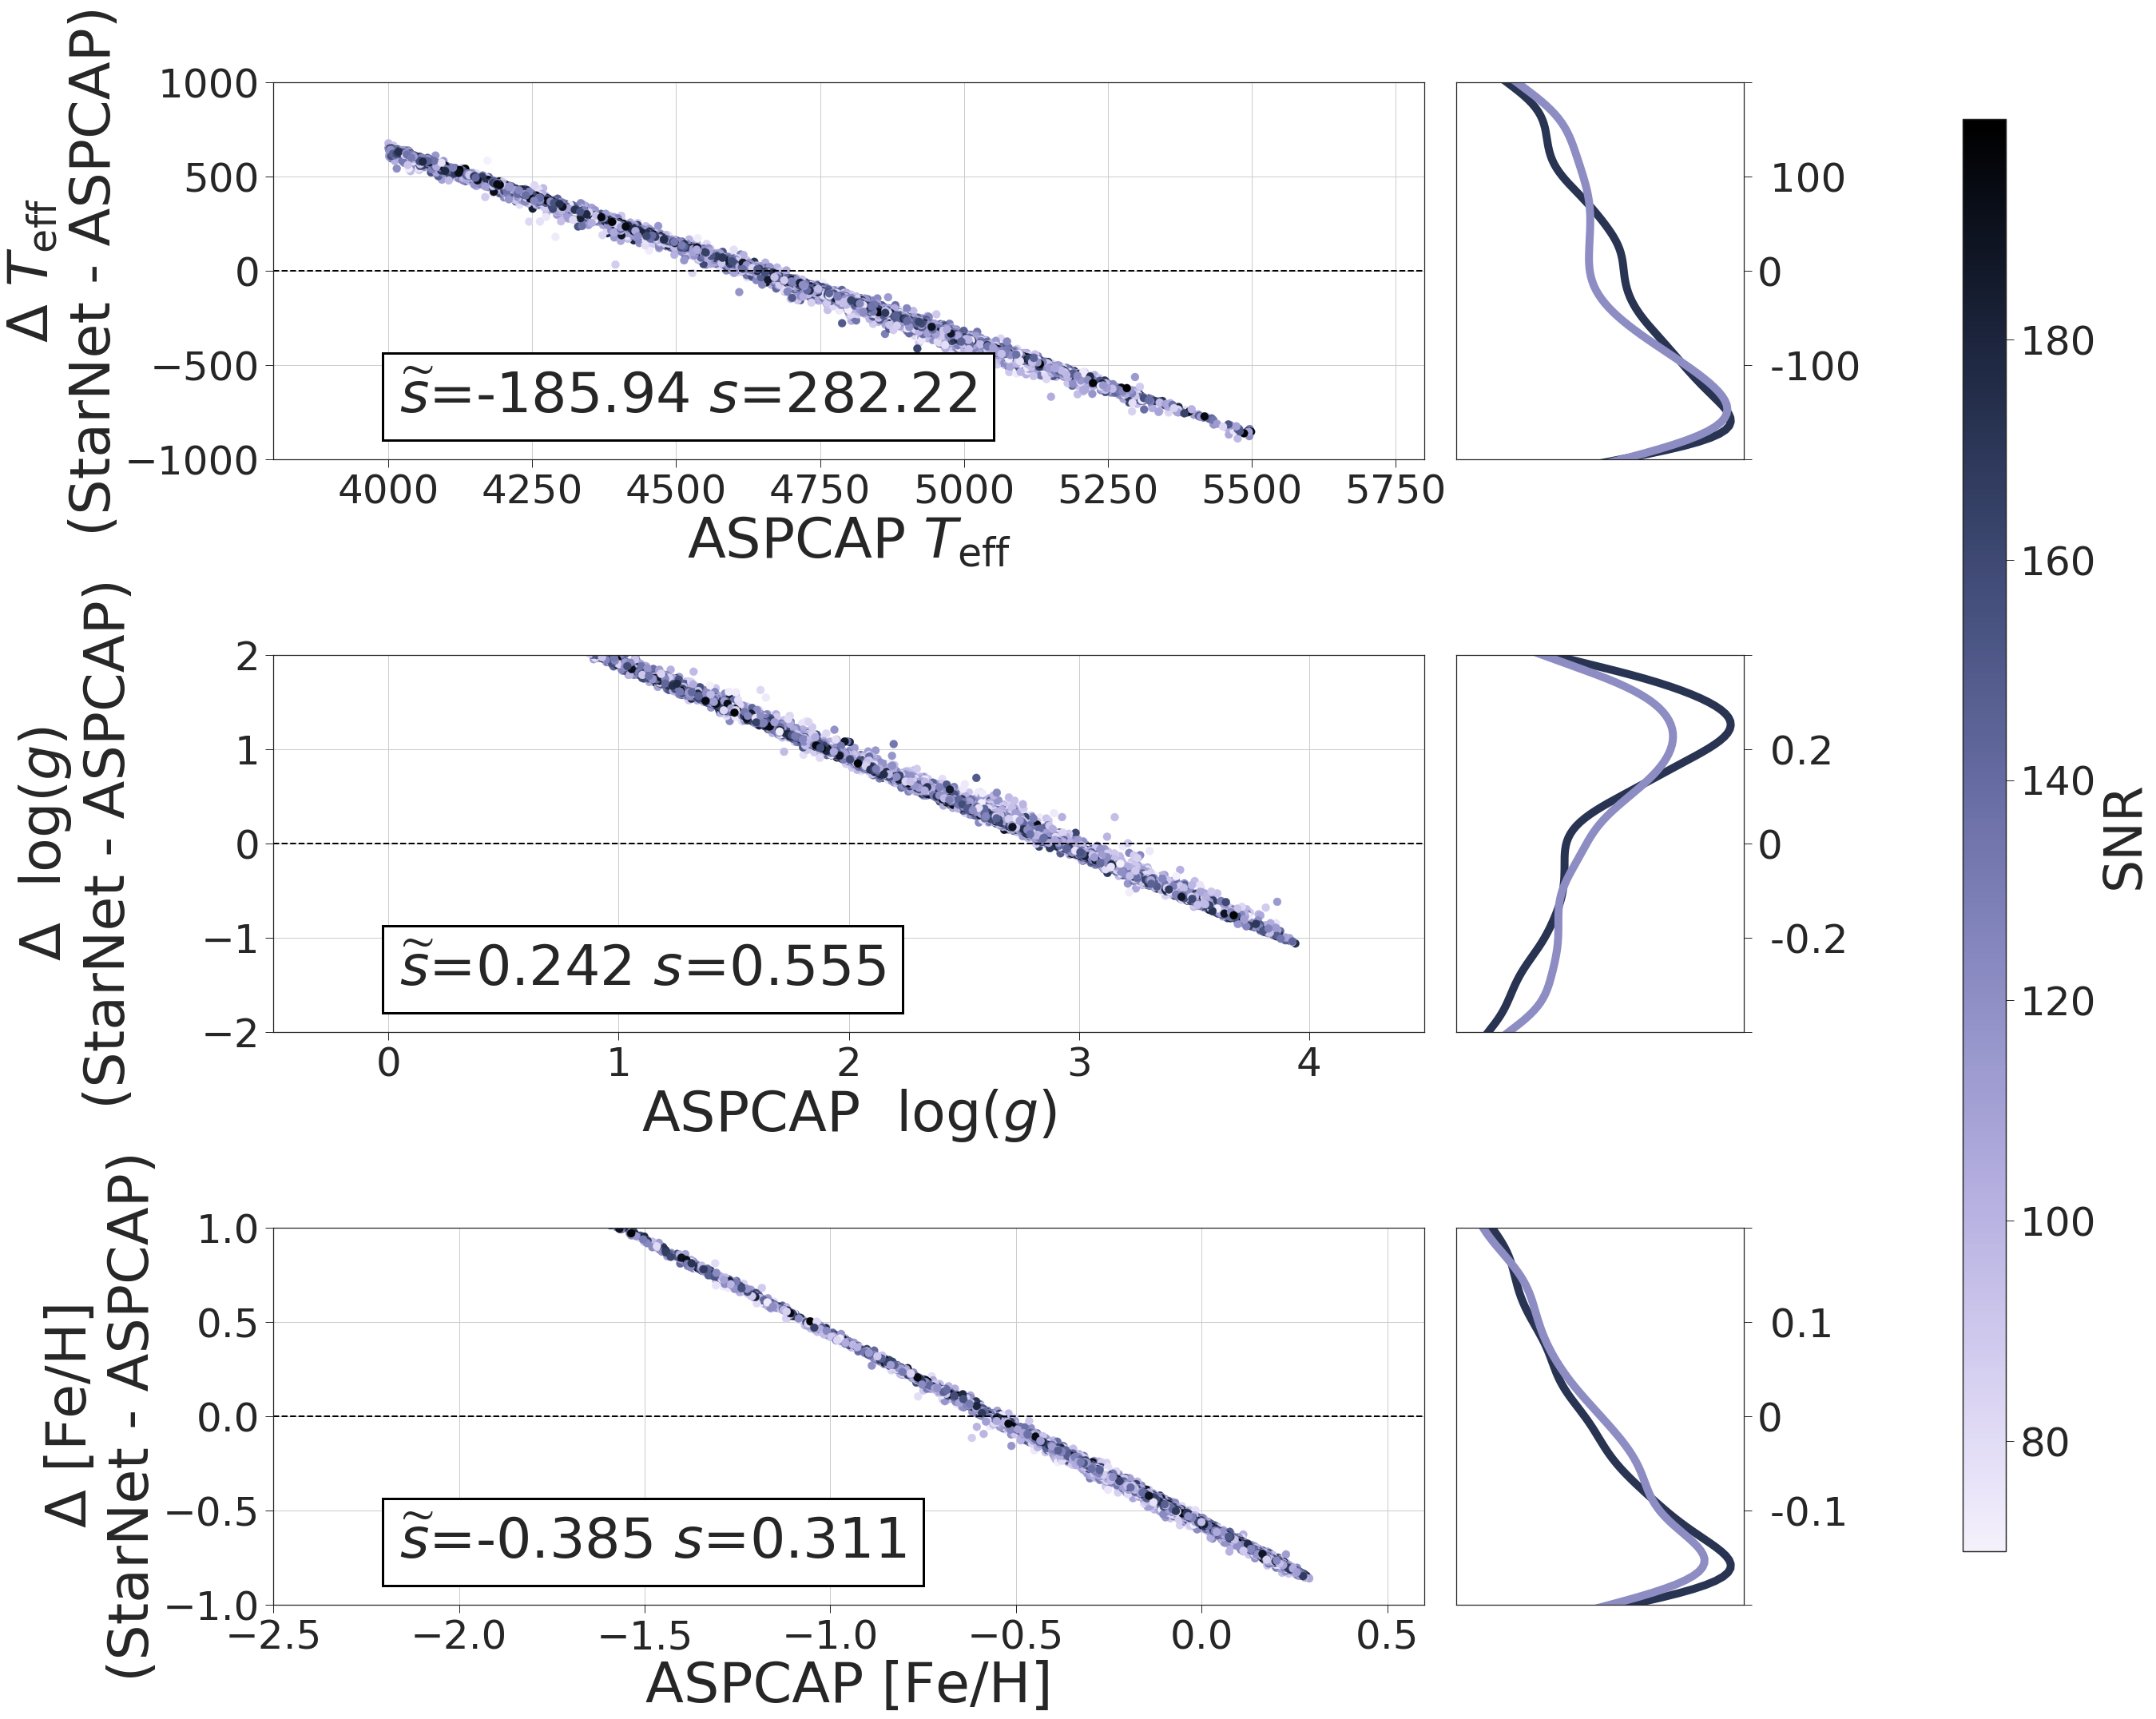

In [28]:
all_targets = test_2_labels
all_pred = test_2_pred
z = test_2_snr

x_lab='ASPCAP'
y_lab='StarNet'


resid = all_pred - all_targets
bias = np.median(resid, axis=0)
scatter = np.std(resid, axis=0)

indices_a = np.where(z>=150)
indices_b = np.where(z<100)
resid_a = resid[indices_a,:]
resid_b = resid[indices_b,:]

#r2 = r2_score(all_targets, all_pred,multioutput='raw_values')


cmap = sns.cubehelix_palette(8, start=2.8, rot=.1, dark=0, light=.95, as_cmap=True)

lims = [[(3800,5800),(-0.50,4.50),(-2.5,0.6)],[(-1000,1000),(-2.0,2.0),(-1.,1.)]]
ditribution_lims = [(-200,200),(-0.4,0.4),(-0.2,0.2)]

fig = plt.figure(figsize=(38, 30)) 
gs = gridspec.GridSpec(3, 2,  width_ratios=[4., 1])


for i in range(num_labels):

    ax0 = plt.subplot(gs[i,0])
    points = ax0.scatter(all_targets[:,i], resid[:,i], c=z, s=100, cmap=cmap)
    sns.set_style("ticks")
    
    ax0.set_xlabel('ASPCAP ' + label_names[i], fontsize=70)
    if i==1:
        ax0.set_ylabel('$\Delta$ ' + label_names[i]+ '\n('+y_lab+' - '+x_lab+')\n', fontsize=70)
    else:
        ax0.set_ylabel('$\Delta$ ' + label_names[i]+ '\n('+y_lab+' - '+x_lab+')', fontsize=70)  
    
    ax0.set_facecolor('white')
    ax0.tick_params(labelsize=50, width=1, length=10)
    ax0.set_xlim(lims[0][i])
    ax0.set_ylim(lims[1][i])
    ax0.plot([lims[0][i][0],lims[0][i][1]], [0,0], 'k--', lw=2)
    ax0.grid(True)
 
    xmin, xmax = ditribution_lims[i]
    
    y_a = resid_a[0,:,i][(resid_a[0,:,i]>=xmin)&(resid_a[0,:,i]<=xmax)]
    y_b = resid_b[0,:,i][(resid_b[0,:,i]>=xmin)&(resid_b[0,:,i]<=xmax)]
    
    ax1 = plt.subplot(gs[i,1])
    a = sns.distplot(y_a, vertical=True,hist=False, rug=False, ax=ax1,kde_kws={"color": cmap(200), "lw": 10})
    b = sns.distplot(y_b,vertical=True,hist=False, rug=False, ax=ax1,kde_kws={"color": cmap(100), "lw": 10})
    
    a.set_ylim(ditribution_lims[i])
    b.set_ylim(ditribution_lims[i])
    
    ax1.tick_params(
    axis='x',          
    which='both',     
    bottom='off',      
    top='off',         
    labelbottom='off',width=1,length=10)
    
    ax1.tick_params(
    axis='y',          
    which='both',   
    left='off',     
    right='on',        
    labelleft='off',
    labelright='on',
    labelsize=50,width=1,length=10)
    
    ax1.set_yticklabels([' ',' '+str(ditribution_lims[i][0]/2),'0',' '+str(ditribution_lims[i][1]/2),' '])

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=3)

    
    if i==0:
        plt.figtext(0.185, (1-((i*0.332)+0.24)),
                    '$\widetilde{m}$='+'{0:.2f}'.format(bias[i])+' $s$='+'{0:.2f}'.format(scatter[i]),
                    size=70, bbox=bbox_props)
    else:
        plt.figtext(0.185, (1-((i*0.332)+0.24)),
                    '$\widetilde{m}$='+'{0:.3f}'.format(bias[i])+' $s$='+'{0:.3f}'.format(scatter[i]),
                    size=70, bbox=bbox_props)

cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.83])
fig.colorbar(points,cax=cbar_ax)
cbar = fig.colorbar(points, cax=cbar_ax, extend='neither', spacing='proportional', orientation='vertical', format="%.0f")
cbar.set_label('SNR', size=65)
cbar.ax.tick_params(labelsize=50,width=1,length=10) 

cbar.ax.set_yticklabels(['80','100','120','140','160','180'])

plt.tight_layout()
fig.subplots_adjust(right=0.8)

plt.show()